In [3]:
import pandas as pd
import numpy as np
import dateparser
import matplotlib.pyplot as plt
%matplotlib inline

#Help functions for correcting the 'tld' and 'org' columns
def get_tld(x):
    if type(x) != list:
        return np.nan
    if x[-1] == 'in' and len(x) == 2 and x[-2] in ['ac', 'co']:
        return x[-2] + '.' + 'in'
    else:
        return x[-1]
def get_org(x):
    if type(x) != list:
        return np.nan
    if len(x) == 1:
        return np.nan
    if x[-1] == 'in' and x[-2] in ['ac', 'co'] and len(x) == 3:
        return x[-3]   
    if x[-1] == 'in' and x[-2] in ['ac', 'co'] and len(x) == 2:
        return np.nan   
    return x[-2]

# Data Preprocessing

In [2]:
#load the original data set
df = pd.read_csv('train.csv', index_col = 0)
#df = pd.read_csv('test.csv', index_col = 0)

In [ ]:
#Obtain clean date

#1. There are no missing values in the date column, but several formats exist:
#(a) Sun, 28 Aug 2016 00:17:44 +0000
#(b) 11-MAR-2018 20:40:58
#(c) Mon, 8 Apr 2013 09:59:21
#(d) 25 Apr 2019 07:13:43 -0400
#...
#2. There are also incorrect time zones values, '+0580', which I changed to '0530'

df['date'] = df['date'].str.replace(r' \(.*\)', '')
df['date'] = df['date'].str.rstrip()
df['date'] = df['date'].str.replace('-0000', '+0000')
df['date'] = df['date'].str.replace('0580', '0530')
df['date'] = df['date'].apply(dateparser.parse, languages=['en'])

In [17]:
#Generate year, month, day, day of the week, hour, minute, second and timezone from date
df['year'] = df['date'].apply(lambda x:x.year)
df['month'] = df['date'].apply(lambda x:x.month)
df['day'] = df['date'].apply(lambda x:x.day)
df['hour'] = df['date'].apply(lambda x:x.hour)
df['minute'] = df['date'].apply(lambda x:x.minute)
df['second'] = df['date'].apply(lambda x:x.second)
df['weekday'] = df['date'].apply(lambda x:x.weekday())
df['timezone'] = df['date'].apply(lambda x:x.tzname())

In [18]:
#Merge all the upper case and lower case mailtype calsses by lowering-case the whole column
#e.g. multipart/alternative and Multipart/Alternative
df['mail_type'] = df['mail_type'].str.lower()

In [19]:
#Save df to train_clean.csv
df.to_csv('train_clean.csv')
#df.to_csv('test_clean.csv')

# Feature Engineering

In [7]:
#Assumption: if a domain always sends a particular type of emails, then it will always send this type of emails.
#Pairs is a table with such pair of orgs and labels

df_org_label_count = df_train.groupby(['org', 'label']).count().iloc[:,0]
df_org_label_count = df_org_label_count.to_frame().reset_index()
pairs = df_org_label_count[df_org_label_count.groupby('org')['org'].transform(len) == 1]
pairs.columns = ['org', 'label', 'count']
pairs = dict(zip(pairs['org'], pairs['label']))

In [115]:
#Holiday list

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays()
holidays = [x.strftime("%Y-%m-%d") for x in holidays]

In [8]:
pairs

{'000webhost': 0,
 '126': 2,
 '172758': 0,
 '2shared': 0,
 '365premium': 0,
 '3digiprints': 0,
 '3dr': 3,
 '60': 0,
 '86282': 0,
 'BillHowell': 0,
 'GoDaddy': 0,
 'MachineLearningMastery': 0,
 'Magento': 3,
 'Neo4j': 0,
 'TRM': 0,
 'aamaadmiparty': 0,
 'account': 0,
 'account-nvidia': 0,
 'accountprotection': 0,
 'accounts': 0,
 'ace2three': 0,
 'acm': 0,
 'acmicpc': 0,
 'admin': 0,
 'adultfriendfinder': 1,
 'adum': 0,
 'af3': 0,
 'afraid': 0,
 'agencenavigoannuel': 0,
 'agents': 0,
 'aicte-india': 0,
 'airfrance': 0,
 'airindia': 0,
 'airserbia': 0,
 'airvistara': 3,
 'alchemyapi': 0,
 'alerts': 0,
 'altera': 0,
 'am': 0,
 'amadeus': 0,
 'ames-it-solutions': 0,
 'apiai-a32c4dd4b716': 3,
 'apiai-a7bf10d275b3': 0,
 'applemusic': 3,
 'aptech': 0,
 'asana': 0,
 'aspiringminds': 0,
 'astrospeak': 3,
 'asus': 0,
 'asusindiapromo': 0,
 'asvspoof': 0,
 'atcoder': 0,
 'atlassian': 0,
 'atmel': 0,
 'audible': 3,
 'autodesk360': 0,
 'avast': 0,
 'awseducate': 3,
 'axisbank': 0,
 'barbeque-nation

# PCA

In [68]:
#Dimensionality Reduction
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
%matplotlib inline  

pca = PCA(n_components=500)
pca.fit(X) 
X_pca = pca.transform(X)
X_pca_test = pca.transform(X_test)

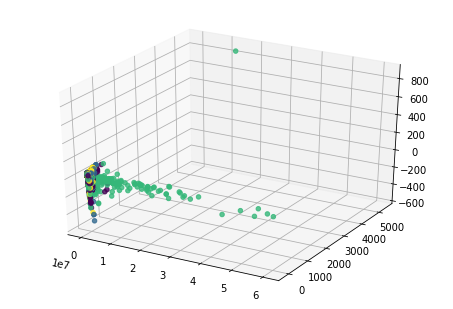

In [12]:
#Filter out outliners
x1 = X_pca[:, 0]
x2 = X_pca[:, 1]
x3 = X_pca[:, 2]

fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(x1, x2, x3, c=y, alpha=0.8)

In [19]:
#Random Forest Cross Validation

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 300)

print(cross_validate(model, X_pca, y, cv=5, scoring='f1_macro'))

{'fit_time': array([93.78264594, 96.05388713, 94.25368428, 93.16093349, 92.82308674]), 'score_time': array([0.36783504, 0.36383772, 0.4217813 , 0.36436105, 0.35698581]), 'test_score': array([0.95102715, 0.94842011, 0.95416895, 0.95018432, 0.95189054]), 'train_score': array([1., 1., 1., 1., 1.])}


In [21]:
#Model Training
model.fit(X_pca, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
#Generate our predictions
y_test = model.predict(X_pca_test).astype(int)
res = pd.DataFrame({'ID': np.arange(len(y_test)),
                    'label': y_test})
res.to_csv('submission3.csv', index=False)

# SVM

In [2]:
#Read train_clean.csv and test_clean.csv
df_train = pd.read_csv('train_clean.csv', index_col = 0)
df_test = pd.read_csv('test_clean.csv', index_col = 0)

In [8]:
#Concatenate data together for feature engineering

n = len(df_train)
temp = pd.concat([df_train, df_test], axis=0, sort=False).drop(['label'], axis=1)

#Add 'org_freq' and 'tld_freq' columns
for col in ['org', 'tld', 'mail_type', 'timezone']:
    encoding = temp.groupby(col).size()/len(temp)
    temp[col + '_freq'] = temp[col].map(encoding)

#Onehot encode data
catogorical = ['org', 'tld', 'mail_type', 'timezone']
temp = pd.concat([temp, pd.get_dummies(temp[catogorical], drop_first=True)], axis=1)
temp = temp.drop(catogorical, axis=1)

#Drop apparently non-important features, and date
temp = temp.drop(['bcced', 'designation', 'salutations', 'date'], axis=1)

In [9]:
#Standarize data
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler().fit(temp)
temp = transformer.transform(temp)

#Fill nan with -1
temp = np.nan_to_num(temp, -1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


In [10]:
#Split the data to X, y and X_test
X = temp[:n]
X_test = temp[n:]
y = df_train['label']

In [ ]:
#Cross Validation

from sklearn.model_selection import cross_validate
from sklearn.svm import SVC

model = SVC()

print(cross_validate(model, X, y, cv=5, scoring='f1_macro', n_jobs=-1))

In [ ]:
model = SVC(C=100, kernel='linear')
model.fit(X[:20000], y[:20000])

In [262]:
model.score(X[20000:], y[20000:])

0.9347107438016529

# Some explorations

In [62]:
df_train = pd.read_csv('train_clean.csv', index_col = 0)
df_test = pd.read_csv('test_clean.csv', index_col = 0)
temp = pd.concat([df_train, df_test], axis=0, sort=False)

In [127]:
temp['tld'][temp['tld'].str.contains('.', na=False, regex=False)].unique()

array(['ac.in', 'paypal.com', 'evernote.com', 'pytorch.org',
       'iiitd.ac.in', 'xoom.com', 'netflix.com', 'sdconnect.in',
       'cardekhomailer.com', 'intercom-mail.com', 'efinmail.com',
       'emails-makemytrip.com', 'co.in', 'nvidia.com', 'gov.in',
       'microsoft.com', 'instagram.com', 'foodpanda.in', 'jabong.com',
       'skype.com', '4shared.com', 'grammarly.com', 'google.com',
       'mpg.de', 'apple.com', 'findstay.in', 'hp.com',
       'mail.coursera.org', 'bsnl.co.in', 'speakingtree.in',
       'bookmyshow.com', 'itunes.com', 'ebay.in', 'ieee.org',
       'goindigo.in', 'androidzoom.com', 'iitm.ac.in',
       'hostingdepago.com', 'reliancegeneral.co.in', 'goodreads.com',
       'vincerowatches.com', 'quikr.com', 'twitter.com', 'wix.com',
       'pinterest.com', 'olacabs.com', 'mobikwik.com', 'linkedin.com',
       'asana.com', 'join.me', 'asus.com', 'mailer.surveygizmo.com',
       'paytm.com', 'cardekho.com', 'mail.intercom.io', 'godaddy.com',
       'Apple.com', 'bir

In [210]:
#Concatenate data together for feature engineering

#Encode labels to numerical values
n = len(df_train)
temp = pd.concat([df_train, df_test], axis=0, sort=False).drop(['label'], axis=1)

#Correct the 'org' and 'tld' columns and lowercase them
split_res = temp['tld'].str.split('.')
true_tld = split_res.map(get_tld)
true_org = split_res.map(get_org)
temp['tld'] = true_tld.fillna(temp['tld']).str.lower()
temp['org'] = true_org.fillna(temp['org']).str.lower()


In [217]:
temp['org'].unique()

array(['amazon', 'linkedin', 'quora', 'iiitd', 'paypal', 'twitter',
       'nvidia', 'ieee', 'crazydomains', 'freshersworld', 'usebackpack',
       'inoxmovies', 'statebankrewardz', 'piazza', 'geniecabs',
       'fccashback', 'evernote', 'xprize', 'coursera', 'axisbank',
       'pytorch', 'codalab', 'google', 'pvrcinemas', 'naaptoldeals',
       'glassdoor', 'hackerrankmail', 'xoom', nan, 'netflix', 'sdconnect',
       'cocubes', 'cardekhomailer', 'ndtvecommerce', 'datacamp',
       'brilliant', 'projecteuler', 'udacity', 'paytm', 'intercom-mail',
       'state', 'efinmail', 'mentor', 'researchgatemail', 'dailyspeak',
       'ni', 'angel', 'centralesupelec', 'emails-makemytrip', 'youtube',
       'spoj', 'phpclasses', 'brandshop', 'innerchef', 'ticket-airfrance',
       'gov', 'codecademy', 'khanacademy', 'ruprr', 'microsoft',
       'topcoder', 'repositoryhosting', 'htc', 'geeksforgeeks',
       'hackerrank', 'flipkartletters', 'dropbox', 'slack', 'instagram',
       'foodpanda', 'one

In [216]:
temp2[temp['tld']=='int']

,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body,year,month,day,hour,minute,second,weekday,timezone
14591,2018-09-03 19:36:17+00:00,esa,int,0,0,text/html,0,2,1,0,75,907,2018,9,3,19,36,17,0,UTC\+00:00
18056,2017-09-28 20:11:34+00:00,copernicus,esa.int,0,0,multipart/mixed,0,1,1,0,31,498,2017,9,28,20,11,34,3,UTC\+00:00
658,2018-06-05 08:04:26+00:00,esa,int,0,0,text/html,0,2,1,0,75,907,2018,6,5,8,4,26,1,UTC\+00:00
1229,2017-09-28 11:17:19+00:00,copernicus,esa.int,0,0,multipart/mixed,0,1,1,0,30,382,2017,9,28,11,17,19,3,UTC\+00:00
6652,2018-03-29 17:13:45+00:00,copernicus,esa.int,0,0,multipart/mixed,0,1,1,0,30,382,2018,3,29,17,13,45,3,UTC\+00:00


In [ ]:
#Duplicates detection
#There are duplicates within the train set, the test set and each between the train and test set!
#Solution drop duplicate rows in the excel file

In [90]:
print(np.unique(X, axis=0).shape)
print(X.shape)
print(np.unique(X_test, axis=0).shape)
print(X_test.shape)

(24474, 967)
(24840, 967)
(10544, 967)
(10647, 967)


In [95]:
print(np.unique(temp, axis=0).shape)

(34927, 967)


In [98]:
24474+10544

35018

In [100]:
print(np.unique(y,axis=0).shape)
print(y.shape)

(4,)
(24840,)


# Neural Network

In [223]:
#Read train_clean.csv and test_clean.csv
df_train = pd.read_csv('train_clean.csv', index_col = 0)
df_test = pd.read_csv('test_clean.csv', index_col = 0)

In [224]:
#Concatenate data together for feature engineering

n = len(df_train)
temp = pd.concat([df_train, df_test], axis=0, sort=False).drop(['label'], axis=1)

#Correct the 'org' and 'tld' columns and lowercase them
split_res = temp['tld'].str.split('.')
true_tld = split_res.map(get_tld)
true_org = split_res.map(get_org)
temp['tld'] = true_tld.fillna(temp['tld']).str.lower()
temp['org'] = true_org.fillna(temp['org']).str.lower()

#Take the log of 'chars_in_subject', 'chars_in_body' and 'urls' columns
log = ['chars_in_subject', 'chars_in_body', 'urls']
temp[log] = np.log(temp[log] + 1)

#Add 'org_freq' and 'tld_freq' columns
for col in ['org', 'tld', 'mail_type', 'timezone']:
    encoding = temp.groupby(col).size()/len(temp)
    temp[col + '_freq'] = temp[col].map(encoding)

#Onehot encode data
catogorical = ['org', 'tld', 'mail_type', 'timezone']
temp = pd.concat([temp, pd.get_dummies(temp[catogorical], drop_first=True)], axis=1)
temp = temp.drop(catogorical, axis=1)

#Drop apparently non-important features, and date
temp = temp.drop(['bcced', 'designation', 'salutations', 'date'], axis=1)

In [225]:
#Standarize data
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler().fit(temp)
temp = transformer.transform(temp)

#Fill nan with -1
temp = np.nan_to_num(temp, -1)

In [226]:
#Split the data to X, y and X_test
X = temp[:n]
X_test = temp[n:]
y = df_train['label']

In [227]:
#Onehot-encode y
y = pd.get_dummies(y)

In [228]:
#NN
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping

n_features = X.shape[1]
input_tensor = Input(shape=(n_features,))
layer1 = Dense(100, activation='relu')(input_tensor)
layer2 = Dense(100, activation='relu')(layer1)
layer3 = Dense(100, activation='relu')(layer2)
output_tensor = Dense(4, activation='sigmoid')(layer3)
model = Model(input_tensor, output_tensor)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Using TensorFlow backend.


In [229]:
model.fit(X, y, validation_split=0.3, batch_size=16, epochs=100, callbacks=[es])

Train on 17388 samples, validate on 7452 samples
Epoch 1/100
17388/17388 [==============================] - 4s 205us/step - loss: 0.3346 - accuracy: 0.8670 - val_loss: 0.2578 - val_accuracy: 0.8936
Epoch 2/100
17388/17388 [==============================] - 4s 202us/step - loss: 0.2236 - accuracy: 0.9140 - val_loss: 0.2247 - val_accuracy: 0.9122
Epoch 3/100
17388/17388 [==============================] - 5s 294us/step - loss: 0.2005 - accuracy: 0.9217 - val_loss: 0.2156 - val_accuracy: 0.9157
Epoch 4/100
17388/17388 [==============================] - 4s 223us/step - loss: 0.1873 - accuracy: 0.9277 - val_loss: 0.2152 - val_accuracy: 0.9145
Epoch 5/100
17388/17388 [==============================] - 3s 174us/step - loss: 0.1790 - accuracy: 0.9302 - val_loss: 0.2281 - val_accuracy: 0.9185
Epoch 6/100
17388/17388 [==============================] - 3s 175us/step - loss: 0.1710 - accuracy: 0.9342 - val_loss: 0.2175 - val_accuracy: 0.9200
Epoch 7/100
17388/17388 [==============================] 

In [54]:
model.evaluate(X, y)

24840/24840 [==============================] - 1s 47us/step


[0.15909310742828772, 0.943719806763285]

In [19]:
y_test = model.predict(X_test).argmax(axis=1)
res = pd.DataFrame({'ID': np.arange(len(y_test)),
                    'label': y_test})
res.to_csv('submission-NN.csv', index=False)

# Gradient Boosting

In [172]:
#Cross Validation

from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators = 300)

print(cross_validate(model, X, y, cv=5, scoring='f1_macro'))

{'fit_time': array([29.98285484, 29.97687054, 26.86665082, 29.52052808, 29.64791417]), 'score_time': array([0.08495164, 0.08495569, 0.08595252, 0.09294653, 0.09092283]), 'test_score': array([0.94345937, 0.9444076 , 0.94413334, 0.94525616, 0.94328965]), 'train_score': array([0.95983127, 0.96006077, 0.9601345 , 0.95916251, 0.95950221])}


In [69]:
#Model Training
model = GradientBoostingClassifier(n_estimators = 300)
model.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [70]:
#Generate our predictions
y_test = model.predict(X).astype(int)
res = pd.DataFrame({'ID': np.arange(len(y_test)),
                    'label': y_test})
res.to_csv('submission-GB.csv', index=False)

In [71]:
model.score(X, y)

0.962842190016103

# Random Forest

In [4]:
#Read train_clean.csv and test_clean.csv
df_train = pd.read_csv('train_clean.csv', index_col = 0)
df_test = pd.read_csv('test_clean.csv', index_col = 0)

In [42]:
#Concatenate data together for feature engineering

#Encode labels to numerical values
n = len(df_train)
temp = pd.concat([df_train, df_test], axis=0, sort=False).drop(['label'], axis=1)

#Seperate the 'mail_type' column
temp['mail_type'] = temp['mail_type'].str.strip()
temp['mail_type_1'] = temp['mail_type'].str.split('/',expand=True)[0]
temp['mail_type_2'] = temp['mail_type'].str.split('/',expand=True)[1]

#Correct the 'org' and 'tld' columns and lowercase them
split_res = temp['tld'].str.split('.')
true_tld = split_res.map(get_tld)
true_org = split_res.map(get_org)
temp['tld'] = true_tld.fillna(temp['tld']).str.lower()
temp['org'] = true_org.fillna(temp['org']).str.lower()

###
temp['org_tld'] = temp['tld'] + '.' + temp['org']
temp['org_tld'] = temp['org_tld'].str.strip()
temp['org_tld'] = temp['org_tld'].str.lower()
temp['org_tld'] = temp['org_tld'].str.split('.')
temp = temp.drop(['org', 'tld'], axis =1)
temp['org_tld'] = temp['org_tld'].fillna('Nan')

temp = temp.drop('org_tld', 1).join(
    pd.get_dummies(
        pd.DataFrame(temp['org_tld'].tolist()).stack()).astype(int).sum(level=0))
catogorical = ['mail_type_1', 'mail_type_2', 'timezone']
###

#catogorical = ['org', 'tld', 'mail_type_1', 'mail_type_2', 'timezone']
temp[catogorical] = temp[catogorical].apply(lambda x: pd.factorize(x)[0])

#Add 'org_freq' and 'tld_freq' columns
for col in catogorical:
    encoding = temp.groupby(col).size()/len(temp)
    temp[col + '_freq'] = temp[col].map(encoding)

#Add 'is_holiday' columns - Doesn't seem to work
#temp['is_holiday'] = temp['date'].apply(lambda x:x[:10]).isin(holidays)

#Drop apparently non-important features, and date and mailtype
drop_c = ['bcced', 'designation', 'salutations', 'date', 'mail_type', 'mail_type_1_freq', 'mail_type_1']
temp = temp.drop(drop_c, axis=1)

In [43]:
#Split the data to X, y and X_test
X = temp[:n]
X_test = temp[n:]
y = df_train['label']

In [10]:
#Cross Validation

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100)

print(cross_validate(model, X, y, cv=5, scoring='f1_macro', return_train_score=True))

{'fit_time': array([12.553128  , 12.74917245, 12.78111911, 13.53734231, 12.93262959]), 'score_time': array([0.30392337, 0.28392887, 0.27594709, 0.29592705, 0.29228616]), 'test_score': array([0.1903152 , 0.19725079, 0.19268929, 0.200224  , 0.19838734]), 'train_score': array([0.99559048, 0.99513371, 0.99560679, 0.99538874, 0.99602746])}


In [328]:
#Model Training
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [329]:
#Generate our predictions
y_test = model.predict(X_test).astype(int)
res = pd.DataFrame({'ID': np.arange(len(y_test)),
                    'label': y_test})
res.to_csv('submission.csv', index=False)

In [330]:
model.feature_importances_[model.feature_importances_.argsort()[::-1]]

array([0.20147906, 0.13174169, 0.08412687, 0.07515236, 0.07283776,
       0.06901138, 0.06378221, 0.05691535, 0.04718192, 0.03557186,
       0.02418004, 0.02094048, 0.02047868, 0.01602045, 0.01589014,
       0.01528764, 0.01493279, 0.01339131, 0.01075369, 0.01032434])

In [331]:
X.columns[model.feature_importances_.argsort()[::-1]]

Index(['org_freq', 'org', 'tld', 'urls', 'chars_in_body', 'images', 'year',
       'tld_freq', 'ccs', 'chars_in_subject', 'timezone', 'hour',
       'timezone_freq', 'second', 'day', 'month', 'minute', 'mail_type_2',
       'mail_type_2_freq', 'weekday'],
      dtype='object')

# Majority Voter

In [235]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

clf1 = RandomForestClassifier(n_estimators=20)
clf2 = GradientBoostingClassifier(n_estimators=20)
clf3 = AdaBoostClassifier(n_estimators=20)
clfs = [('1', clf1), ('2', clf2), ('3', clf3)]

model = VotingClassifier(estimators=clfs, voting='soft', weights=[4, 1, 1])
print(cross_validate(model, X, y, cv=5, scoring='f1_macro', n_jobs=-1))

{'fit_time': array([4.30760336, 4.3206048 , 4.32758403, 4.19048905, 4.0275867 ]), 'score_time': array([0.06297207, 0.10159349, 0.07697463, 0.12692881, 0.0969429 ]), 'test_score': array([0.94826636, 0.9464066 , 0.9473167 , 0.94927333, 0.94339472])}
